<a href="https://colab.research.google.com/github/AnastasiiaX/airbnb-berlin-munich-price-modeling/blob/main/Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Authors:

Anastasiia Kosareva

Luis Rheinert

https://insideairbnb.com/get-the-data/

For supervised learning we chose airbnb generally quarterly data for the last 12 months for Berlin, Berlin, Germany and Munich, Bavaria, Germany.
We found this data quite interesting for our purposes as it contains about 18 columns that can be used to build models.

We wanted to use Oikotie API for analyzing finnish real estates, but it was impossible again, but for other reasons. The website was updated and it was impossible to use existed API for it.

We used both classification and regression models. The first method is  Regression with Gradient Boosted Trees (XGBoost) and the second one is Random Forest Classification and exploratory data analysis (EDA) to categorize and analyze price data for Berlin and Munich.



## Step 1: Data Uploading

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving berlin_airbnb.csv to berlin_airbnb (1).csv
Saving munich_airbnb.csv to munich_airbnb (1).csv


## Step 2: Data Preprocessing

Before we start any work with the data, we need to install all the libraries that we might need when building the model.


Once the libraries have been installed, we can move on to the most basic datasets modifications. In the very beggining we want to delete 5 columns. Some of them doesn't have data at all (for example for Munich data: neighbourhood_group and license), some columns contain textual information, which, even if transformed into numerical, will not contain any critical information for our model. Also, we drop rows with NoN values.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform

berlin_data = pd.read_csv("berlin_airbnb.csv")
munich_data = pd.read_csv("munich_airbnb.csv")

berlin_data.drop(columns=['neighbourhood_group', 'license', 'neighbourhood', 'host_name', 'name'], inplace=True)
munich_data.drop(columns=['neighbourhood_group', 'license', 'neighbourhood', 'host_name', 'name'], inplace=True)

berlin_data.dropna(inplace = True)
munich_data.dropna(inplace = True)

The .get_dummies() function creates dummy (indicator) variables from categorical variables. Each level of the categorical variable gets its own column - a dummy variable. The dummy variables take on the value “1” if the original categorical variable was that level or “0” if not.

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [ ]:
# One-hot encode 'room_type'
berlin_data = pd.get_dummies(berlin_data, columns=['room_type'], drop_first=False, dtype=int)
munich_data = pd.get_dummies(munich_data, columns=['room_type'], drop_first=False, dtype=int)

Airbnb data contain columns with geographical longitude and latitude as apartments coordinates. Each of us has traveled somewhere at least once in our lives and understands how much the distance from the center affects the price of an apartment.

We decided to calculate a new feature for distance to the city center. We found city center coordinates and calculate a distance from each apartment to city center.

In [ ]:
def distance_to_center(df, city_center_lat, city_center_lon):
    df['distance_to_center'] = np.sqrt((df['latitude'] - city_center_lat)**2 + (df['longitude'] - city_center_lon)**2)
    return df

# Assume Berlin center at (52.5246, 13.3691), Munich center at (48.1371, 11.5761)
berlin_data = distance_to_center(berlin_data, 52.5249, 13.3691)
munich_data = distance_to_center(munich_data, 48.1371, 11.5761)

Drop the columns 'longitude' and 'latitude',because this information is not entirely relevant and useful, as it is already displayed in the 'distance_to_center' column.

In [ ]:
berlin_data.drop(columns=['latitude', 'longitude'], inplace=True)
munich_data.drop(columns=['latitude', 'longitude'], inplace=True)

Create a new column 'days_since_last_review' to see how often new reviews appear.

In [ ]:
# Convert 'last_review' to datetime
berlin_data['last_review'] = pd.to_datetime(berlin_data['last_review'])
munich_data['last_review'] = pd.to_datetime(munich_data['last_review'])

# Calculate the number of days since the last review
today = pd.to_datetime('today')  # You can use the current date or any reference date
berlin_data['days_since_last_review'] = (today - berlin_data['last_review']).dt.days
munich_data['days_since_last_review'] = (today - munich_data['last_review']).dt.days

# Drop the 'last_review' column after converting it to 'days_since_last_review'
berlin_data.drop(columns=['last_review'], inplace=True)
munich_data.drop(columns=['last_review'], inplace=True)

The data contains features of various dimensions and scales altogether. Different scales of the data features affect the modeling of a dataset adversely, what leads to a biased outcome of predictions in terms of misclassification error and accuracy rates. Thus, it is necessary to Scale the data prior to modeling.

In [ ]:
scaler = StandardScaler()
numerical_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                     'calculated_host_listings_count', 'availability_365', 'distance_to_center', 'days_since_last_review']

berlin_data[numerical_columns] = scaler.fit_transform(berlin_data[numerical_columns])
munich_data[numerical_columns] = scaler.fit_transform(munich_data[numerical_columns])


## Step 3: Feature Selection

Before selecting the assigning the features, we need to see which variables are highly correlated with each other in each of the datasets and discard them when training the model for better accuracy.

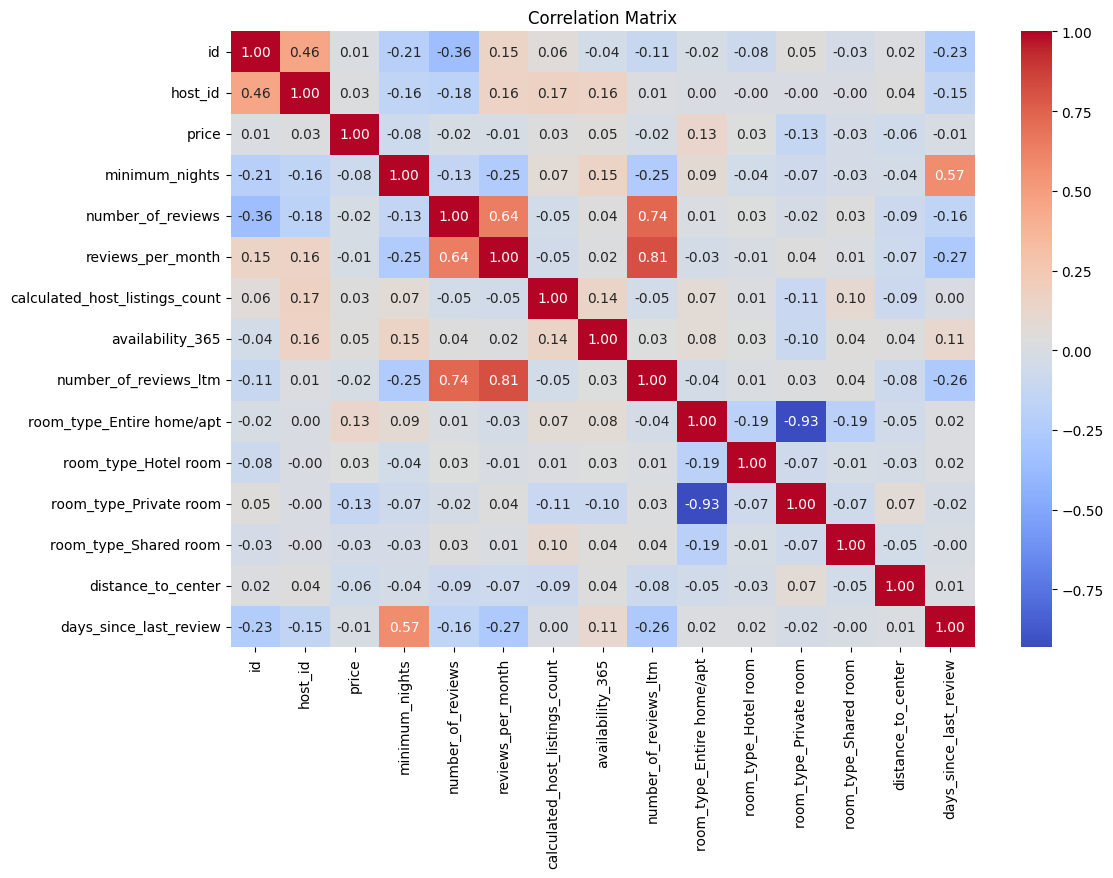

Highly Correlated Feature Pairs: {('reviews_per_month', 'number_of_reviews_ltm'), ('room_type_Entire home/apt', 'room_type_Private room'), ('number_of_reviews_ltm', 'reviews_per_month'), ('room_type_Private room', 'room_type_Entire home/apt')}


In [ ]:
correlation_matrix = berlin_data.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Set a correlation threshold
threshold = 0.8

# Find correlated feature pairs
correlated_features = set()
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            correlated_features.add((i, j))

print("Highly Correlated Feature Pairs:", correlated_features)


For Berlin data we see high correlation between room type columns, but we can't discard any of them because each one contains valuable information. We probably see high correlation values ​​because it was previously a single column.

But what we see else is high correlation between 'reviews_per_month', 'number_of_reviews_ltm'. So, we will drop one of these column, for example 'reviews_per_month'.

https://medium.com/@yatharthranjan/finding-top-correlation-pairs-from-a-large-number-of-variables-in-pandas-f530be53e82a[linkkiteksti](https://)

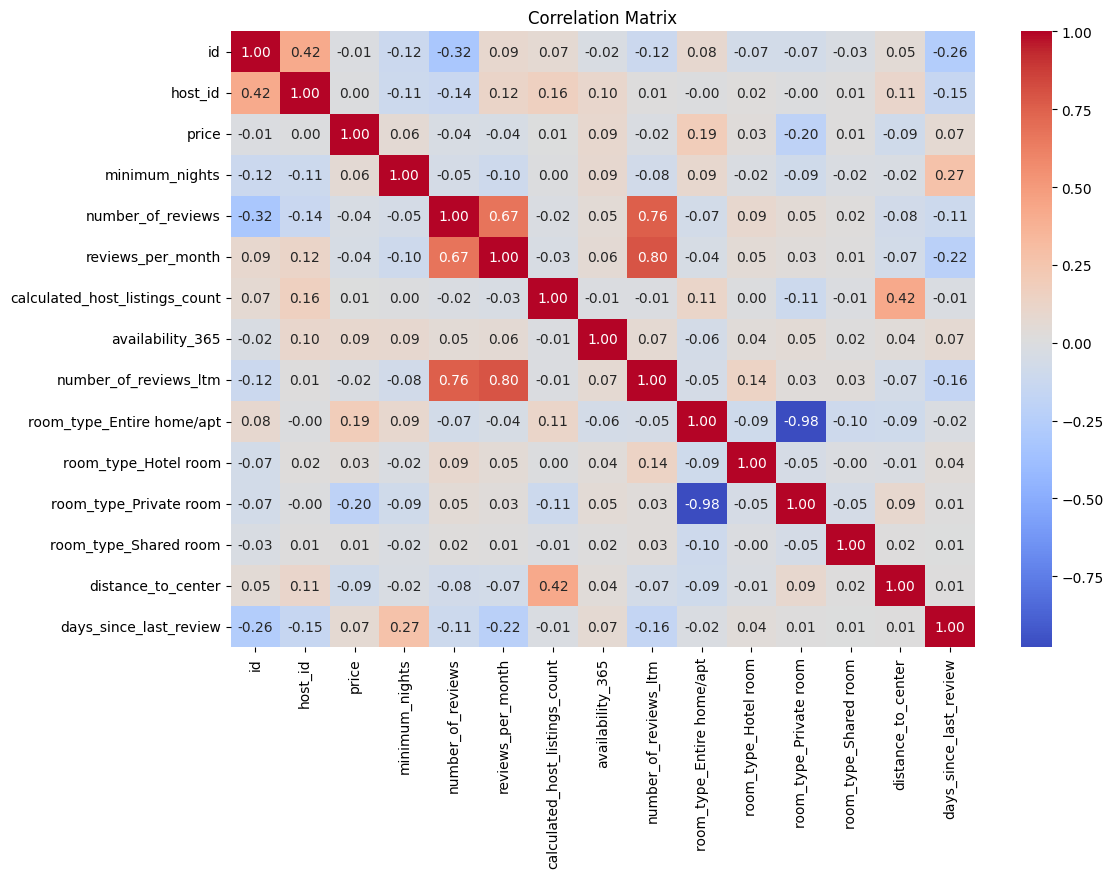

Highly Correlated Feature Pairs: {('room_type_Entire home/apt', 'room_type_Private room'), ('room_type_Private room', 'room_type_Entire home/apt')}


In [ ]:
correlation_matrix = munich_data.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Set a correlation threshold
threshold = 0.8

# Find correlated feature pairs
correlated_features = set()
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            correlated_features.add((i, j))

print("Highly Correlated Feature Pairs:", correlated_features)


There is no correlation between 'reviews_per_month', 'number_of_reviews_ltm'. So, for Munich data let's leave everything as is.

In [ ]:
X_berlin = berlin_data.drop(columns=['price', 'reviews_per_month'])
y_berlin = berlin_data['price']

X_munich = munich_data.drop(columns=['price'])
y_munich = munich_data['price']

## Step 4: Train-Test Split
As usually we devide data like 80% for training, 20% for testing.


In [ ]:
X_train_berlin, X_test_berlin, y_train_berlin, y_test_berlin = train_test_split(X_berlin, y_berlin, test_size=0.2, random_state=42)
X_train_munich, X_test_munich, y_train_munich, y_test_munich = train_test_split(X_munich, y_munich, test_size=0.2, random_state=42)

## Step 5: Model Initialization
We chose XGBoost model for our data. Why?
https://xgboost.readthedocs.io/en/stable/

XGBoost is tree-Based Model. Tree-based models are particularly effective for datasets with non-linear relationships and interactions between features. They are adept at capturing complex patterns and are resilient to outliers and noisy data. This makes them an excellent choice for our regression task.

'At its core, XGBoost builds a series of decision trees sequentially, each one correcting the errors of the previous one. This is achieved through the use of gradient boosting, where the algorithm focuses on the residuals (the differences between the actual and predicted values) in each iteration.' https://medium.com/@jyotsna.a.choudhary/mastering-xgboost-a-technical-guide-for-intermediate-machine-learning-practitioners-f7ad167c6865

We also use RandomizedSearchCV. RandomizedSearchCV is technique used for hyperparameter tuning in machine learning.
'In machine learning, hyperparameters are parameters whose values are set before the learning process begins. These parameters are not learned from the data and must be predefined. They help in controlling the learning process and can significantly influence the performance of the model. For example: in a decision tree, the maximum depth of the tree is a hyperparameter.'
https://medium.com/@dancerworld60/demystifying-hyperparameter-tuning-gridsearchcv-and-randomizedsearchcv-2123bf3fb6c8

In [ ]:
y_train_berlin_log = np.log1p(y_train_berlin)
y_test_berlin_log = np.log1p(y_test_berlin)
y_train_munich_log = np.log1p(y_train_munich)
y_test_munich_log = np.log1p(y_test_munich)

# Instantiate XGBoost model
xgboost_model_berlin = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model_munich = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter tuning using RandomizedSearchCV for more efficient search
param_dist = {
    'max_depth': [3, 6, 10],
    'learning_rate': uniform(0.01, 0.2),  # Uniform distribution for learning rate
    'n_estimators': [100, 200, 500],
    'subsample': uniform(0.7, 0.3),  # Random uniform distribution
    'colsample_bytree': uniform(0.7, 0.3),  # Random uniform distribution
    'min_child_weight': [1, 5, 10]
}

# RandomizedSearchCV for Berlin model
rand_search_berlin = RandomizedSearchCV(estimator=xgboost_model_berlin, param_distributions=param_dist,
                                        n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)
rand_search_berlin.fit(X_train_berlin, y_train_berlin_log)

# RandomizedSearchCV for Munich model
rand_search_munich = RandomizedSearchCV(estimator=xgboost_model_munich, param_distributions=param_dist,
                                        n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)
rand_search_munich.fit(X_train_munich, y_train_munich_log)

# Get best models from RandomizedSearchCV
best_model_berlin = rand_search_berlin.best_estimator_
best_model_munich = rand_search_munich.best_estimator_

# Make predictions with the best models
y_pred_berlin_log = best_model_berlin.predict(X_test_berlin)
y_pred_munich_log = best_model_munich.predict(X_test_munich)

# Inverse the log transformation for predictions
y_pred_berlin = np.expm1(y_pred_berlin_log)
y_pred_munich = np.expm1(y_pred_munich_log)

# Evaluate the models
mape_berlin = mean_absolute_percentage_error(y_test_berlin, y_pred_berlin)
mape_munich = mean_absolute_percentage_error(y_test_munich, y_pred_munich)

accuracy_berlin = (1 - mape_berlin) * 100
accuracy_munich = (1 - mape_munich) * 100

print(f"Berlin Model Accuracy: {accuracy_berlin:.2f}%")
print(f"Munich Model Accuracy: {accuracy_munich:.2f}%")

# Cross-validation (optional for further validation)
cv_scores_berlin = cross_val_score(best_model_berlin, X_train_berlin, y_train_berlin_log, cv=5, scoring='neg_mean_absolute_percentage_error')
cv_scores_munich = cross_val_score(best_model_munich, X_train_munich, y_train_munich_log, cv=5, scoring='neg_mean_absolute_percentage_error')

print(f"CV Scores Berlin: {cv_scores_berlin}")
print(f"CV Scores Munich: {cv_scores_munich}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Berlin Model Accuracy: 65.71%
Munich Model Accuracy: 56.51%
CV Scores Berlin: [-0.0719477  -0.07125605 -0.07195557 -0.07342875 -0.07471562]
CV Scores Munich: [-0.07803535 -0.07883491 -0.07562877 -0.0845222  -0.07935989]


P.S. We chose RandomizedSearchCV instead of GridSearchCV, because it's faster.
Models' results are not very accurate, only 65.71% and 56.51%, but it's the best what we achieved.

# **Part 2: Classification of the Airbnb Data.**
In this part we will start classifying the data into different categories based on their features that we will get from the csv files. In the first part we will create a model that puts every entry in one of the 5 price categories. The second model will determine the type of room based on the same features as the first model.
# **Step 1: Read in data**
The first step is to read in the data a second time and save them in a different variable. We are doing this because it caused problems using the same data for the Part 1 and Part 2. For example, some features already got deleted or normalized in the first part, which lead to weird predictions.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

berlin_data_new = pd.read_csv("berlin_airbnb.csv")
munich_data_new = pd.read_csv("munich_airbnb.csv")

# **Step 2: Recalculate the distances**
In this step we claculate the distance for the new data set. But this time we use a different method. For better understanding the scatter plots that will be created later we had to use a method which could calculate the distance in kilometers based on the change of longitude and latitude. For this we used the Haversine formula:

*   a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
*   c = 2 ⋅ atan2( √a, √(1−a) )
*   d = R ⋅ c
*  	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km)
[Source](https://www.movable-type.co.uk/scripts/latlong.html)

The new calculated distance will be saved to the DataFrame and the method will be used for both Munich and Berlin data.

In [ ]:
# Function to calculate the distance in kilometers based on the longitude and latitude with the Haversine formula
def distance_to_center(df, city_center_lat, city_center_lon):
    # latitude and longitude from the city center and from the location of the Airbnb
    lat1 = np.radians(df['latitude'])
    lon1 = np.radians(df['longitude'])
    lat2 = np.radians(city_center_lat)
    lon2 = np.radians(city_center_lon)

    #Calculating the difference between the city center's longitude and latitude compared to the Airbnb
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1

    # Using the Haversine formula
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # radius of the earth
    R = 6371.0

    #Putting the calculated value as a new column in the dataframe
    df['distance_to_center'] = R * c

    return df

#Calculating the distance for both dataFrame
berlin_data_new = distance_to_center(berlin_data_new, 52.5249, 13.3691)
munich_data_new = distance_to_center(munich_data_new, 48.1371, 11.5761)


# **Step 3: Model for classifying price categories**
The first part here is to define price categories and their limits and than create those categories for both Munich and Berlin data as a new column in the DataFrame. After this we create our traget values and the define the features that should be used to classify our values. We also create Test and Train data for our model.
To predict the price category we use the RandomForestClassifier model from the sklearn library.
We printed out our results in a confusion matrix and also calculated the accuracy scores. The accuracies are with 61% and 56% not very high but it is harder for the model to predict precisley with the given parameters because the correlation is not very high and distance between the categories is not very high.


Berlin Accuracy: 0.610828488372093


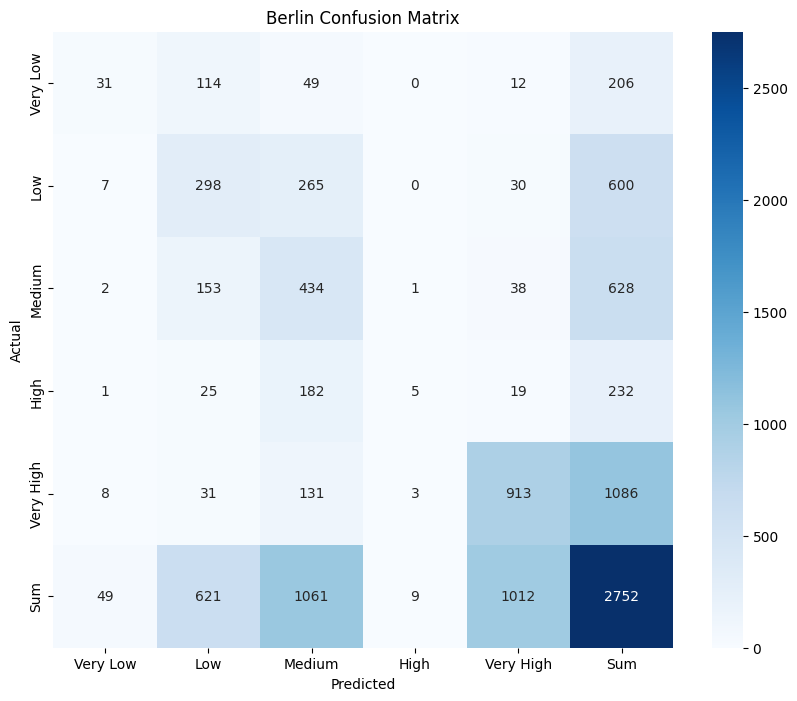


Munich Accuracy: 0.5659259259259259


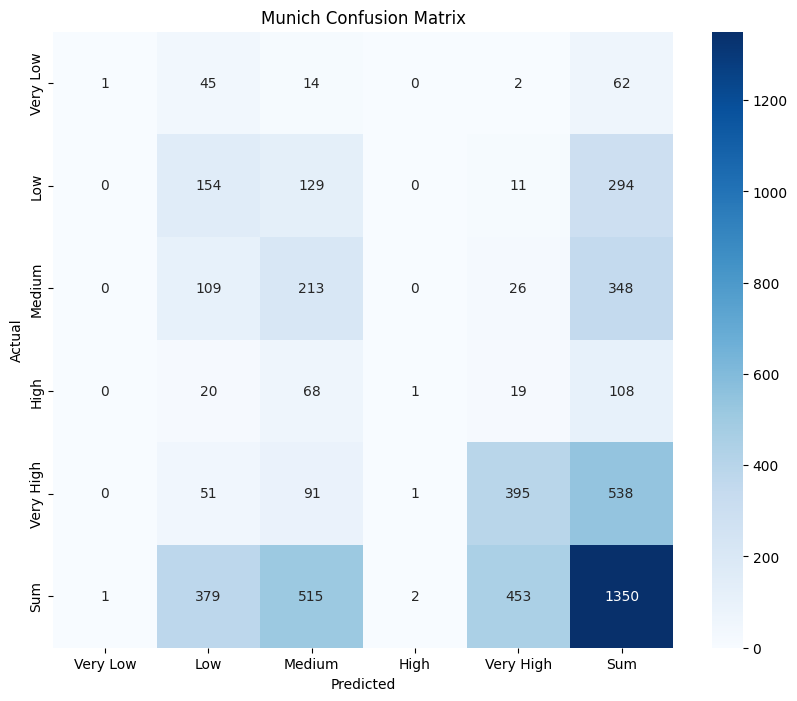

In [ ]:
#Defining the Price categories
def categorize_price(price):
    if price <= 50:
        return "Very Low"
    elif price <= 100:
        return "Low"
    elif price <= 200:
        return "Medium"
    elif price <= 300:
        return "High"
    else:
        return "Very High"

#Creating the price categories for both data
berlin_data_new['price_category'] = berlin_data_new['price'].apply(categorize_price)
munich_data_new['price_category'] = munich_data_new['price'].apply(categorize_price)

#Defining target values and our features for the classifying
X_berlin = berlin_data_new[['availability_365', 'distance_to_center', 'number_of_reviews', 'reviews_per_month', 'minimum_nights', 'availability_365']]
y_berlin = berlin_data_new['price_category']

X_munich = munich_data_new[['availability_365', 'distance_to_center', 'number_of_reviews', 'reviews_per_month', 'minimum_nights', 'availability_365']]
y_munich = munich_data_new['price_category']

# Train-Test-Split for Berlin
X_train_berlin, X_test_berlin, y_train_berlin, y_test_berlin = train_test_split(
    X_berlin, y_berlin, test_size=0.2, random_state=42
)

# Train-Test-Split for Munich
X_train_munich, X_test_munich, y_train_munich, y_test_munich = train_test_split(
    X_munich, y_munich, test_size=0.2, random_state=42
)

# Creating the RandomForest-Modell and fitting the data
model_berlin = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
model_munich = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

model_berlin.fit(X_train_berlin, y_train_berlin)
model_munich.fit(X_train_munich, y_train_munich)

# Letting the model predict the price category
y_pred_berlin = model_berlin.predict(X_test_berlin)
y_pred_munich = model_munich.predict(X_test_munich)


# Creating a confusion matrix
def plot_confusion_matrix(cm, classes, title):
    # Calculating the sums for the columns and rows
    actual_totals = cm.sum(axis=1)
    predicted_totals = cm.sum(axis=0)
    overall_total = cm.sum()

    #Creating extra row and column to see the sum in the matrix
    cm_with_totals = np.vstack((cm, predicted_totals))
    totals_column = np.append(actual_totals, overall_total)
    cm_with_totals = np.column_stack((cm_with_totals, totals_column))
    extended_classes = classes + ["Sum"]

    # Creating the plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_with_totals, annot=True, fmt='d', cmap='Blues', xticklabels=extended_classes, yticklabels=extended_classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Confusion matrix for Berlin with accuracy
print("\nBerlin Accuracy:", accuracy_score(y_test_berlin, y_pred_berlin))
cm_berlin = confusion_matrix(y_test_berlin, y_pred_berlin, labels=["Very Low", "Low", "Medium", "High", "Very High"])
plot_confusion_matrix(cm_berlin, ["Very Low", "Low", "Medium", "High", "Very High"], "Berlin Confusion Matrix")


#Confusion matrix for Munich with accuracy
print("\nMunich Accuracy:", accuracy_score(y_test_munich, y_pred_munich))
cm_munich = confusion_matrix(y_test_munich, y_pred_munich, labels=["Very Low", "Low", "Medium", "High", "Very High"])
plot_confusion_matrix(cm_munich, ["Very Low", "Low", "Medium", "High", "Very High"], "Munich Confusion Matrix")

# **Step 4: Scatter Plot to demonstrate the low Correlation**
Here we created a scatter plot for the data with probably the most interesting features. You would maybe assume that appartments near the city center are more likely to have a lower availability during the year. But this is not true as these to features have a quite low correlation as we already saw in the firt part. Neither the distance nor price category have a large impact on the availability and vice versa. But it seems that appartments from the "Very high" price category have a lower availability than other price segments.

<ipython-input-22-bf91f347f7b5>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  berlin_sampled = berlin_data_new.groupby('price_category').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)
<ipython-input-22-bf91f347f7b5>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  munich_sampled = munich_data_new.groupby('price_category').apply(lambda x: x.sample(n=50, random_state=42)).reset_ind

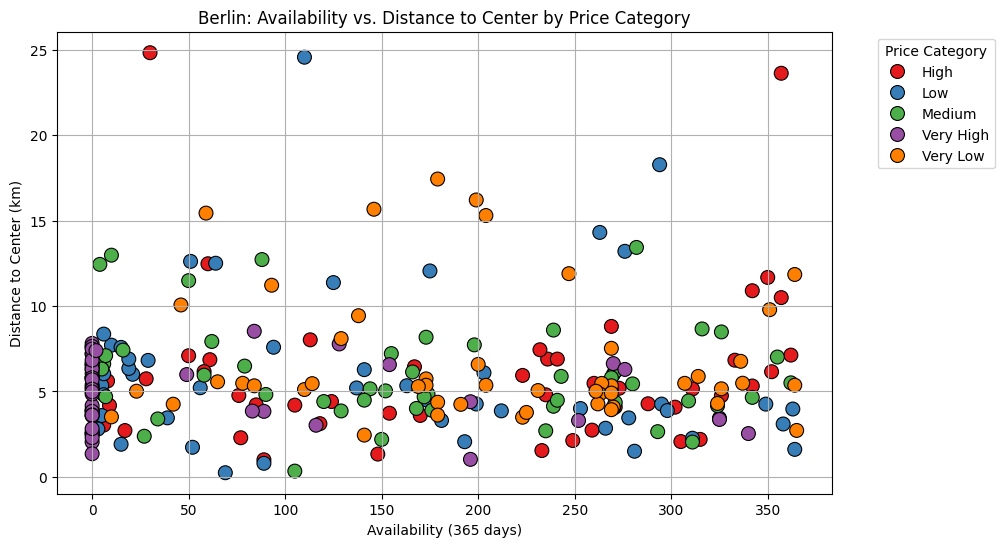

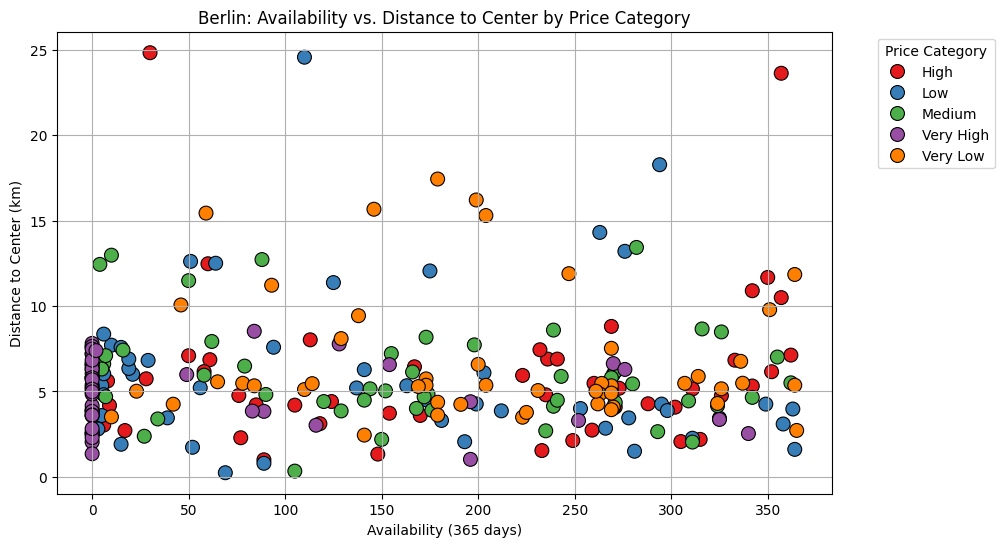

In [ ]:
berlin_sampled = berlin_data_new.groupby('price_category').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)
munich_sampled = munich_data_new.groupby('price_category').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

def create_plot(data, title):
  plt.figure(figsize=(10, 6))
  sns.scatterplot(data=berlin_sampled, x='availability_365', y='distance_to_center', hue='price_category', palette='Set1', s=100, edgecolor='k', marker='o')
  plt.title('Berlin: Availability vs. Distance to Center by Price Category')
  plt.xlabel('Availability (365 days)')
  plt.ylabel('Distance to Center (km)')
  plt.legend(title='Price Category', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(True)
  plt.show()

create_plot(berlin_sampled, "Berlin: Availability vs. Distance to Center by Price Category")
create_plot(munich_sampled, "Munich: Availability vs. Distance to Center by Price Category")

# **Step 5: Classifying room types**
In this part we created a model that can predict the room type of the Airbnb based on 7 features. This time we used the KNN algorithm to classify the Airbnb to their room_types. Because there are NaN values in the data you either have to fill them or drop them. So we decided to drop them for the Berlin data and fill them with the mean value for the Munich data to use both possibilites. The accuracies are pretty good with 79% for Berlin and almost 76% for Munich.

Accuracy Score: 0.7915430267062314


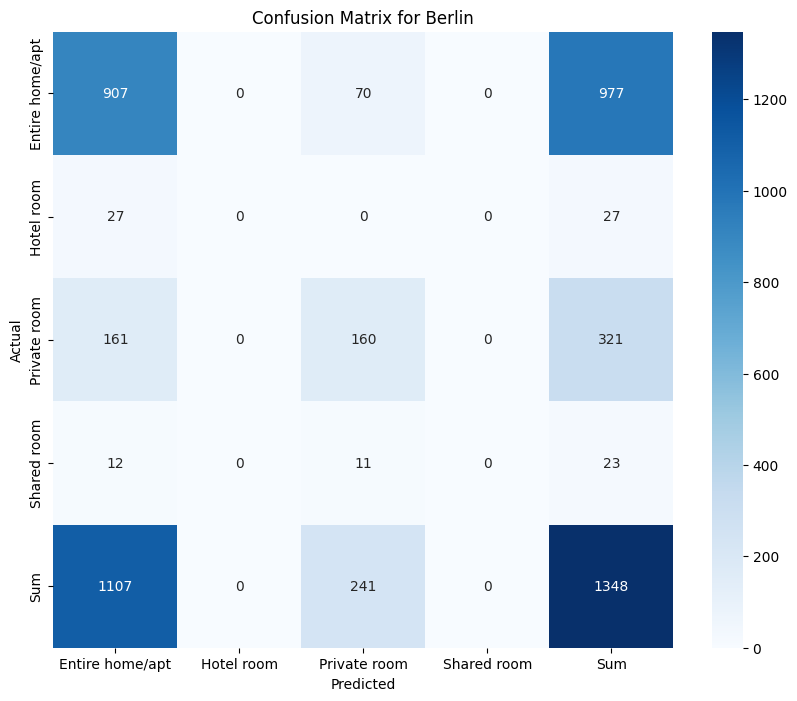

In [ ]:
# Defining features and target
X_berlin_type = berlin_data_new[['availability_365', 'distance_to_center', 'number_of_reviews', 'reviews_per_month', 'minimum_nights', 'availability_365', 'price']]
y_berlin_type = berlin_data_new['room_type']

#Dropping NaN values for Berlin
X_berlin_type = X_berlin_type.dropna()
y_berlin_type = y_berlin_type[X_berlin_type.index]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_berlin_type, y_berlin_type, test_size=0.2, random_state=42)

# Defining and fitting the data for the KNN model

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

#Creating the Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculating the sums and creating a column and a row for it
actual_totals = cm.sum(axis=1)
predicted_totals = cm.sum(axis=0)
overall_total = cm.sum()
cm_with_totals = np.vstack((cm, predicted_totals))
totals_column = np.append(actual_totals, overall_total)
cm_with_totals = np.column_stack((cm_with_totals, totals_column))
extended_classes = np.append(np.unique(y_berlin_type), "Sum")

# Creating the plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_with_totals, annot=True, fmt='d', cmap='Blues', xticklabels=extended_classes, yticklabels=extended_classes)
plt.title("Confusion Matrix for Berlin")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Accuracy Score: 0.7585185185185185


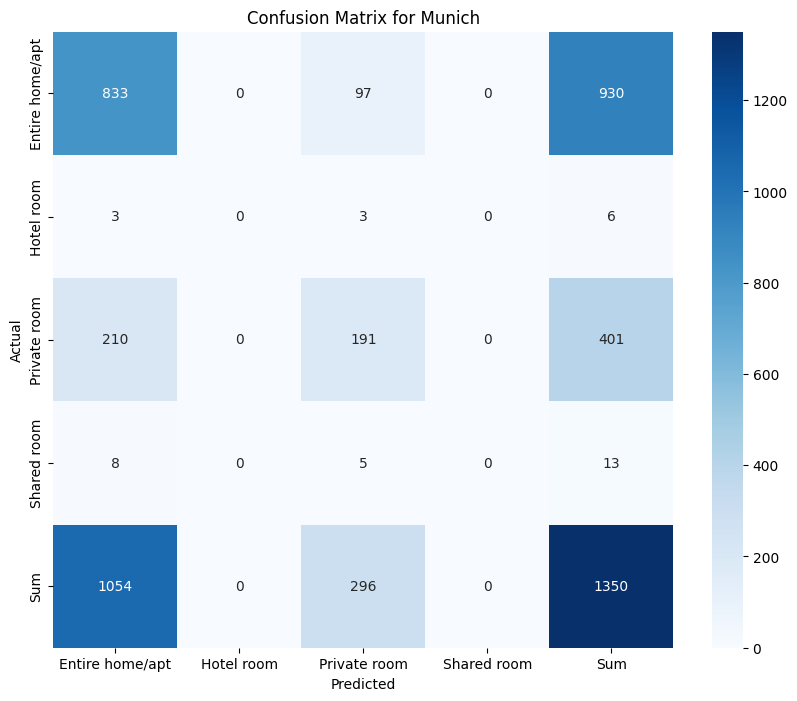

In [ ]:
#Defining the features and the target to predict
X_munich_type = munich_data_new[['availability_365', 'distance_to_center', 'number_of_reviews', 'reviews_per_month', 'minimum_nights', 'availability_365', 'price']]
y_munich_type = munich_data_new['room_type']

#Filling the NaN values for Munich
imputer = SimpleImputer(strategy='mean')  #'median' or 'mean' or 'most_frequent'
X_munich_type = imputer.fit_transform(X_munich_type)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_munich_type, y_munich_type, test_size=0.2, random_state=42)

# Defining model and fitting data
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Calculating the sums and adding a extra column and row
actual_totals = cm.sum(axis=1)
predicted_totals = cm.sum(axis=0)
overall_total = cm.sum()
cm_with_totals = np.vstack((cm, predicted_totals))
totals_column = np.append(actual_totals, overall_total)
cm_with_totals = np.column_stack((cm_with_totals, totals_column))
extended_classes = np.append(np.unique(y_munich_type), "Sum")

# Creating the plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_with_totals, annot=True, fmt='d', cmap='Blues', xticklabels=extended_classes, yticklabels=extended_classes)
plt.title("Confusion Matrix for Munich")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()